# FA24 - Assignment 2 - Feed Forward Neural Networks

### Instructions
- Download the `Cannes_Fashion_dataset.csv` dataset from Moodle.
- Do **NOT** forget to type in your name and AUBNET After this cell.
- Do **NOT** upload the dataset with your submission.
- **If an assignment contains a copied solution, the entire assignment will be awarded 0 points for all individuals submitting the same solution. Furthermore, any solutions generated by AI tools, will also receive 0 points.**
- Name the assignment as follows: **Ast1_AUBNET.ipynb** . Failure to follow this naming convention will result in the notebook **not being graded**.

**Student Information**

**CMPS 364 - Advanced Machine Learning**

**Assignment 2 -** Feed Forward Neural Networks

**By -** Ralph Mouawad - rmm85 - ID 202204667

**To -** Dr. Shady Elbassuoni

## Import Libraries

In [2]:
pip install scikeras

In [3]:
#### Some Libraries to help you out ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

#### Ensure that you use  a **seed = 42** or **random_state=42** for all operations that requires you to use randomness in your assignment.

## 1. Data Preprocessing and Exploration

Preprocess the dataset.<br>
Visualize the features and data.<br>
What insights can be derived from this dataset, and how can we statistically enhance it?<br>

In [5]:
# Read the dataset and clean it
df = pd.read_csv('Cannes_Fashion_dataset.csv')

df = df.drop_duplicates()
df = df.dropna()

df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,Ankle boot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Handbag,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Shirt,0,0,0,0,0,0,0,0,1,...,15,0,0,11,114,50,28,0,0,0
3,Sweater,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,66,31,0,0
4,Sandal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df['label'].value_counts() # Check all the unique labels and their counts

,count
label,
Sandal,7000
Ankle boot,6998
Sneaker,6996
Pants,6994
Dress,6993
Handbag,5600
Sweater,4894
Coat,4198
Top,3500


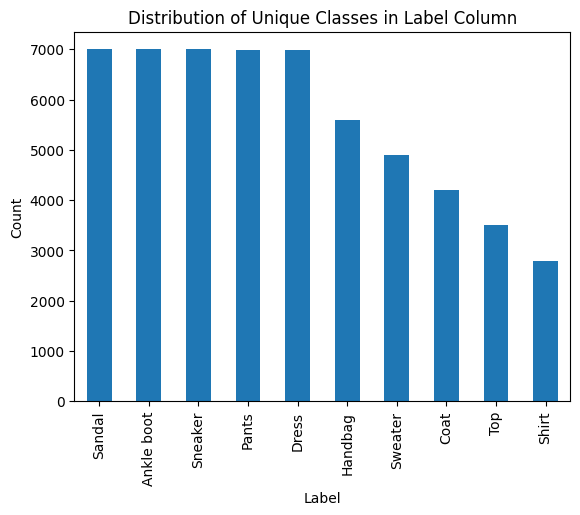

In [6]:
# Plot the distribution of unique classes in the 'label' column
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Unique Classes in Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

We can see that Handbag, Sweater, Coat, Top and Shirt have less instances than the other classes (around 3000 vs. 7000). This can cause the model to overfit the classes that have the most instances and not recognize the minorities.
We will use Stratified Sampling that will make sure that every set (train, val, test) has the same distribution of classes.
We will also use Image Data Generator to create synthetic samples of the underrepresented classes to make sure our model doesn't suffer from bias. We will make sure that all classes are represented equally.

In [6]:
# Split into Input and Output
X = df.drop('label', axis=1)
X = X / 255 # Normalize the data
Y = df[['label']]

## Split Data

Split your data into 80% training, 10% validation, 10 % testing

We set random state = 42 for reproducibility, and stratify for stratified sampling that ensures every set (train, val, test) has the same composition of labels.

In [7]:
# Train, Val, Test Split
X_train_1, X_test, Y_train_1, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_1, Y_train_1, test_size = (0.1/0.9), random_state = 42, stratify = Y_train_1)

It is better to perform encoding after splitting to prevent data leakage. Since we used stratified sampling, we won't face the problem of a class not present in one of the sets (train, val, loss)

In [8]:
# Categorical Encoding for the output
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_val = encoder.transform(Y_val)
Y_test = encoder.transform(Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [9]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

We will generate samples from the minority classes so that our model doesn't suffer from bias

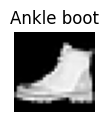

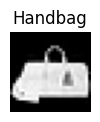

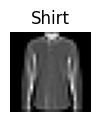

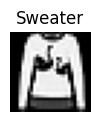

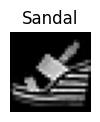

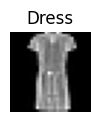

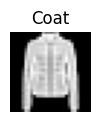

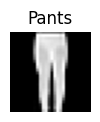

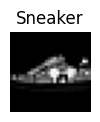

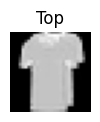

In [10]:
# Let's visualize unique images
unique_labels = Y['label'].unique()
i = 0 # for the subplot
for label in unique_labels:
  i += 1
  index = Y[Y['label'] == label].index[0]
  image = X.iloc[index].values.reshape(28, 28)
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap = 'gray')
  plt.title(label)
  plt.axis('off')
  plt.show()


In [11]:
# Handle imbalanced data with Image Generator
# Only expand training set to keep validation and test sets only with real data

X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)
target_count = 5600 # I want all classes to have max instances

class_labels = np.argmax(Y_train, axis = 1) # Since it is one hot encoded
class_counts = np.bincount(class_labels) # return the number of instances of each class
print('Before Data Augmentation')
for labels, count in zip(encoder.inverse_transform(np.unique(class_labels)), class_counts):
  print(f"{labels}: {count}")


# Image Data Generator
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

augmented_X_train = []
augmented_Y_train = []

for label, count in enumerate(class_counts):

  if count < target_count:
    num_samples_to_generate = target_count - count

    class_indices = np.where(class_labels == label)[0] # retrieve indices of the label
    class_images = X_train_reshaped[class_indices]

    # Generation of synthetic data
    generated_images = 0
    for x_batch in datagen.flow(class_images, batch_size = 1):
      augmented_X_train.append(x_batch[0].reshape(28, 28, 1))
      augmented_Y_train.append(label)
      generated_images += 1
      if generated_images >= num_samples_to_generate:
        break

augmented_X_train = np.array(augmented_X_train)
augmented_Y_train = np.array(augmented_Y_train)

X_train_combined = np.concatenate((X_train_reshaped, augmented_X_train), axis = 0)
Y_train_combined = np.concatenate((Y_train, to_categorical(augmented_Y_train)), axis = 0)

# Shuffle the combined data
indices = np.random.permutation(len(X_train_combined))
X_train_combined = X_train_combined[indices]
Y_train_combined = Y_train_combined[indices]

# Restore to original shape
X_train = X_train_combined.reshape(X_train_combined.shape[0], -1)
Y_train = Y_train_combined

print('After Data Augmentation')
new_class_labels = np.argmax(Y_train, axis = 1) # Since it is one hot encoded
new_class_counts = np.bincount(new_class_labels) # return the number of instances of each class
for label, count in zip(encoder.inverse_transform(np.unique(new_class_labels)), new_class_counts):
    print(f"{label}: {count}")

Before Data Augmentation
Ankle boot: 5598
Coat: 3358
Dress: 5595
Handbag: 4480
Pants: 5595
Sandal: 5600
Shirt: 2238
Sneaker: 5596
Sweater: 3916
Top: 2800
After Data Augmentation
Ankle boot: 5600
Coat: 5600
Dress: 5600
Handbag: 5600
Pants: 5600
Sandal: 5600
Shirt: 5600
Sneaker: 5600
Sweater: 5600
Top: 5600


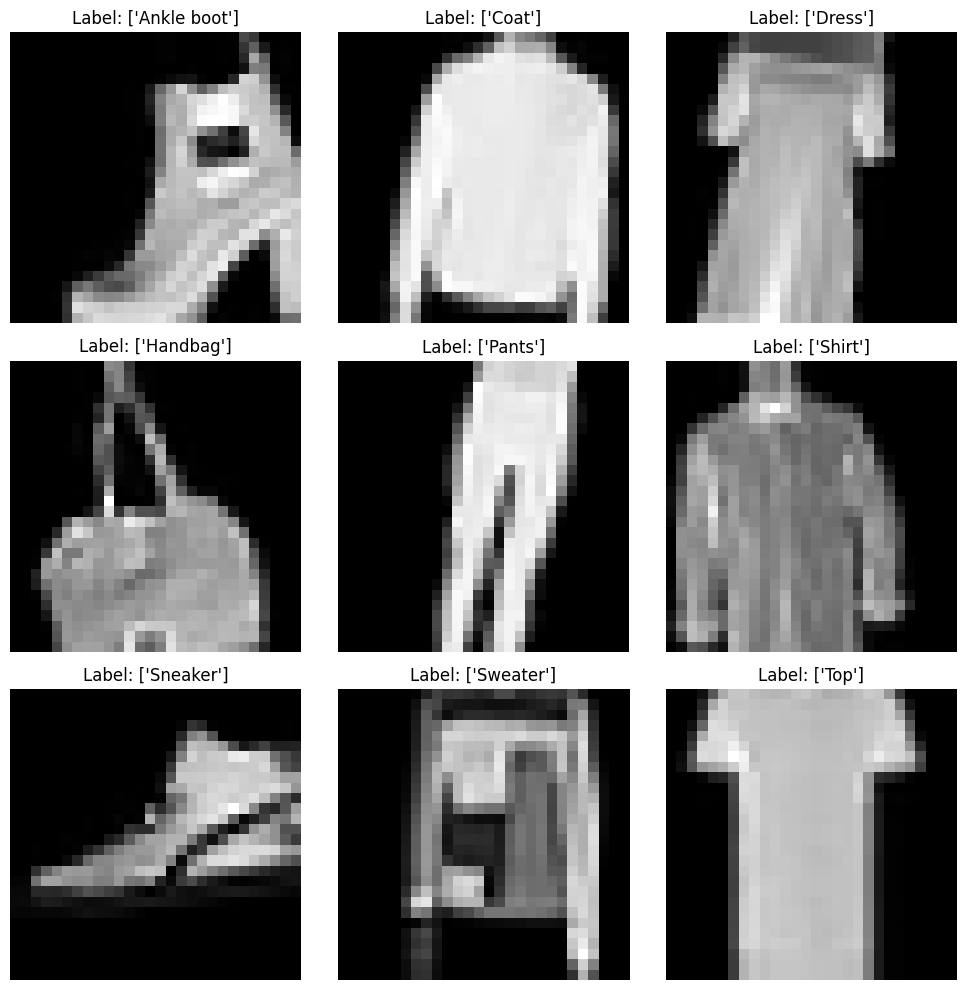

In [24]:
unique_labels, unique_indices = np.unique(augmented_Y_train, return_index=True)

# Number of unique labels
num_unique_labels = len(unique_labels)

plt.figure(figsize=(10, 10))

for i, index in enumerate(unique_indices):
  plt.subplot(3, 3, i+1)
  plt.imshow(augmented_X_train[index].reshape(28, 28), cmap='gray')
  plt.title(f"Label: {encoder.inverse_transform(augmented_Y_train[[index]])}")
  plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Create Model

Create a function that can create any architecture of the Feed Forward
Neural Network.

In [12]:
# Function to create the Model.
def create_model(input_dim, layer_units, output_units, output_activation, learning_rate, decay_steps, decay_rate, dropout_rate): # Check video for explanation of every parameter


  model = Sequential()

  model.add(Input(shape = input_dim))

  for units in layer_units[0:]:
    model.add(Dense(units = units, activation = 'relu'))
    model.add(Dropout(dropout_rate))

  model.add(Dense(units = output_units, activation = output_activation))

  lr_schedule = ExponentialDecay(
      initial_learning_rate = learning_rate,
      decay_steps = decay_steps,
      decay_rate = decay_rate
  )

  optimizer = Adam(learning_rate = lr_schedule)

  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

## Training

Create your model with the function you created above and train it on training dataset.

In [26]:
# Create the Model
input_dim = (X_train.shape[1],)
layer_units = [128, 128, 64, 32, 16] # every entry represents one layer and its corresponding number of neurons
output_units = Y_train.shape[1]
output_activation = 'softmax'# multi class classification
learning_rate = 0.001
decay_steps = 10000
decay_rate = 0.94
dropout_rate = 0.2

model = create_model(input_dim, layer_units, output_units, output_activation, learning_rate, decay_steps, decay_rate, dropout_rate)

# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [27]:
# Fit the Model
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 75, batch_size = 64, callbacks = [early_stopping])

Epoch 1/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4786 - loss: 1.3720 - val_accuracy: 0.8424 - val_loss: 0.4620
Epoch 2/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7463 - loss: 0.7072 - val_accuracy: 0.8517 - val_loss: 0.4077
Epoch 3/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7730 - loss: 0.6220 - val_accuracy: 0.8664 - val_loss: 0.3701
Epoch 4/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7858 - loss: 0.5820 - val_accuracy: 0.8658 - val_loss: 0.3663
Epoch 5/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7971 - loss: 0.5613 - val_accuracy: 0.8855 - val_loss: 0.3479
Epoch 6/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8068 - loss: 0.5365 - val_accuracy: 0.8778 - val_loss: 0.3523
Epoch 7/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8112 - loss: 0.5236 - val_accuracy: 0.8839 - val_loss: 0.3379
Epoch 8/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8183 - loss: 0.5074 - val_accuracy: 0

## Learning Curve

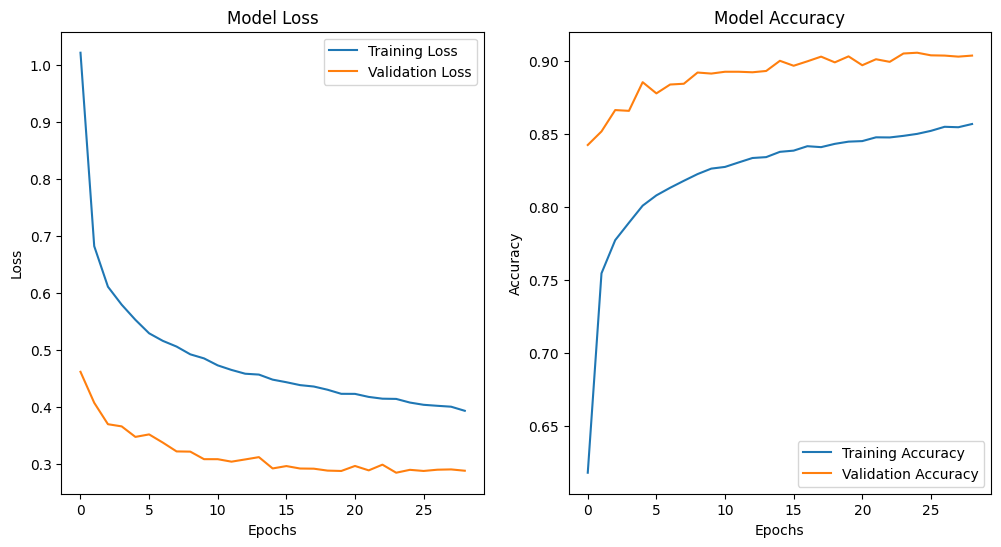

In [28]:
# Plot the Learning Curve
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label  = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

**Model Interpretability**

Training Phase: Training loss decreases over the number of epochs and training accuracy increases. However, validation metrics were better.

Validation Phase: Validation loss decreases more than training, and validation accuracy increased more than training over epochs.

The reasons why validation metrics were better than training can be data augmentation where we might have noisier data and dropout of neurons during training. Since validation data isn't touched, the model can perform a little bit better.

## 3. Hyperparameters Tuning

You will tune the hyperparameters of the above architecture using a random search approach. Utilize insights gained from the learning curve to guide your hyperparameter search process. Once the tuning is complete, report the optimal hyperparameter values, along with the validation accuracy and F-measure obtained from the validation set. At this stage, the purpose of using the validation set is to evaluate and fine-tune the hyperparameters iteratively.

The hyperparameters to be tuned include:

- Learning rate
- Dropout rate
- Mini-batch size
- Learning rate decay
- Number of layers
- Number of Units per each hidden layer
- Early stopping

In [29]:
# Hyperparameter Tuning using Random Search
model = KerasClassifier(build_fn = create_model, input_dim = (X_train.shape[1], ), output_units = Y_train.shape[1], output_activation = 'softmax', verbose = 1)

param_grid = {
    'model__layer_units': [[128, 64, 32], [256, 128, 64], [256, 128, 128, 64], [512, 256, 128, 64, 32]],
    'model__learning_rate': [0.00001, 0.001, 0.01],
    'model__decay_steps': [10000, 20000],
    'model__decay_rate': [0.9, 0.92, 0.94],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64, 128],
}

# Predefined SPlit for Validation Data
X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((Y_train, Y_val))

test_fold = np.concatenate((np.full(X_train.shape[0], -1), np.zeros(X_val.shape[0])), axis =0)
split = PredefinedSplit(test_fold)

random_search = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_grid,
    n_iter = 10,
    cv = split,
    verbose = 2
)

In [30]:
# Fit the Random Search
random_search.fit(X_combined, Y_combined, epochs = 64)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5424 - loss: 1.2248
Epoch 2/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6754 - loss: 0.8729
Epoch 3/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6616 - loss: 0.9187
Epoch 4/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6510 - loss: 0.9516
Epoch 5/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6480 - loss: 0.9733
Epoch 6/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5498 - loss: 1.2050
Epoch 7/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5451 - loss: 1.1273
Epoch 8/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5345 - loss: 1.1916
Epoch 9/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5557 - loss: 1.1396
Epoch 10/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5275 - loss: 1.1741
Epoch 11/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5098 - loss: 1.1880
Epoch 12/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6211 - loss: 1.0391
Epoch 2/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7190 - loss: 0.7811
Epoch 3/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7233 - loss: 0.7774
Epoch 4/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7125 - loss: 0.7869
Epoch 5/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7161 - loss: 0.7876
Epoch 6/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7131 - loss: 0.7894
Epoch 7/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7063 - loss: 0.7817
Epoch 8/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7164 - loss: 0.7936
Epoch 9/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6955 - loss: 0.8374
Epoch 10/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7158 - loss: 0.7981
Epoch 11/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7187 - loss: 0.7915
Epoch 12/64
1750/1750 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6497 - loss: 0.9606
Epoch 2/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7433 - loss: 0.7096
Epoch 3/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7494 - loss: 0.6845
Epoch 4/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7554 - loss: 0.6835
Epoch 5/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7605 - loss: 0.6665
Epoch 6/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7455 - loss: 0.6951
Epoch 7/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7536 - loss: 0.6884
Epoch 8/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7498 - loss: 0.6960
Epoch 9/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7482 - loss: 0.6995
Epoch 10/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7524 - loss: 0.6847
Epoch 11/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7532 - loss: 0.6884
Epoch 12/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6136 - loss: 1.0669
Epoch 2/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7909 - loss: 0.5735
Epoch 3/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8126 - loss: 0.5154
Epoch 4/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8219 - loss: 0.4856
Epoch 5/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8311 - loss: 0.4592
Epoch 6/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8307 - loss: 0.4560
Epoch 7/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8382 - loss: 0.4347
Epoch 8/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8412 - loss: 0.4250
Epoch 9/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8443 - loss: 0.4183
Epoch 10/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8479 - loss: 0.4077
Epoch 11/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8516 - loss: 0.3999
Epoch 12/64
1750/1750 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5494 - loss: 1.2045
Epoch 2/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6563 - loss: 0.9261
Epoch 3/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6652 - loss: 0.8980
Epoch 4/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6591 - loss: 0.9269
Epoch 5/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6585 - loss: 0.9271
Epoch 6/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6648 - loss: 0.9029
Epoch 7/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6621 - loss: 0.9113
Epoch 8/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6550 - loss: 0.9096
Epoch 9/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6525 - loss: 0.9328
Epoch 10/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6628 - loss: 0.9173
Epoch 11/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6600 - loss: 0.9007
Epoch 12/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5798 - loss: 1.1267
Epoch 2/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7331 - loss: 0.7227
Epoch 3/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7433 - loss: 0.7018
Epoch 4/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7550 - loss: 0.6777
Epoch 5/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7516 - loss: 0.6852
Epoch 6/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7531 - loss: 0.6845
Epoch 7/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7550 - loss: 0.6703
Epoch 8/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7551 - loss: 0.6719
Epoch 9/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7636 - loss: 0.6572
Epoch 10/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7612 - loss: 0.6639
Epoch 11/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7529 - loss: 0.6806
Epoch 12/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6593 - loss: 0.9259
Epoch 2/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7947 - loss: 0.5528
Epoch 3/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8156 - loss: 0.4987
Epoch 4/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8253 - loss: 0.4725
Epoch 5/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8357 - loss: 0.4447
Epoch 6/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8395 - loss: 0.4343
Epoch 7/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8437 - loss: 0.4113
Epoch 8/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8480 - loss: 0.4010
Epoch 9/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8492 - loss: 0.3997
Epoch 10/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8521 - loss: 0.3872
Epoch 11/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8583 - loss: 0.3742
Epoch 12/64
1750/1750 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1155 - loss: 2.4038
Epoch 2/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2164 - loss: 2.1286
Epoch 3/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3107 - loss: 1.9575
Epoch 4/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3779 - loss: 1.8121
Epoch 5/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4247 - loss: 1.6755
Epoch 6/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4595 - loss: 1.5736
Epoch 7/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4934 - loss: 1.4836
Epoch 8/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5105 - loss: 1.4109
Epoch 9/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5235 - loss: 1.3680
Epoch 10/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5420 - loss: 1.3166
Epoch 11/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5551 - loss: 1.2727
Epoch 12/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4699 - loss: 1.3923
Epoch 2/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5839 - loss: 1.1034
Epoch 3/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5826 - loss: 1.1191
Epoch 4/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5871 - loss: 1.1211
Epoch 5/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5551 - loss: 1.2107
Epoch 6/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5572 - loss: 1.1687
Epoch 7/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5610 - loss: 1.2418
Epoch 8/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5497 - loss: 1.2119
Epoch 9/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5293 - loss: 1.2312
Epoch 10/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5309 - loss: 1.2253
Epoch 11/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4977 - loss: 1.2703
Epoch 12/64
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1069 - loss: 2.4040
Epoch 2/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1387 - loss: 2.2668
Epoch 3/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1752 - loss: 2.1881
Epoch 4/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2146 - loss: 2.0983
Epoch 5/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2546 - loss: 2.0090
Epoch 6/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2919 - loss: 1.9232
Epoch 7/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3258 - loss: 1.8418
Epoch 8/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3455 - loss: 1.7912
Epoch 9/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3822 - loss: 1.7043
Epoch 10/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3977 - loss: 1.6520
Epoch 11/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4159 - loss: 1.6033
Epoch 12/64
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6190 - loss: 1.0280
Epoch 2/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7938 - loss: 0.5669
Epoch 3/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8151 - loss: 0.5095
Epoch 4/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8276 - loss: 0.4786
Epoch 5/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8332 - loss: 0.4492
Epoch 6/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8387 - loss: 0.4401
Epoch 7/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8455 - loss: 0.4222
Epoch 8/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8497 - loss: 0.4120
Epoch 9/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8509 - loss: 0.4041
Epoch 10/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8521 - loss: 0.4013
Epoch 11/64
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8542 - loss: 0.3861
Epoch 12/64
1925/1925 ━━━━━━━

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=KerasClassifier(build_fn=<function create_model at 0x7ad428af4430>, input_dim=(784,), output_activation='softmax', output_units=10),
                   param_distributions={'batch_size': [32, 64, 128],
                                        'model__decay_rate': [0.9, 0.92, 0.94],
                                        'model__decay_steps': [10000, 20000],
                                        'model__dropout_rate': [0.2, 0.3, 0.4],
                                        'model__layer_units': [[128, 64, 32],
                                                               [256, 128, 64],
                                                               [256, 128, 128,
                                                                64],
                                                               [512, 256, 128,
                                                                64, 32]],
                                        'model__learning_rate': [1e-05, 0.001,
                                                                 0.01]},
                   verbose=2)

In [31]:
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'model__learning_rate': 0.001, 'model__layer_units': [512, 256, 128, 64, 32], 'model__dropout_rate': 0.2, 'model__decay_steps': 20000, 'model__decay_rate': 0.92, 'batch_size': 32}
Best Score:  0.9153117741647311


In [18]:
# Best Model with Early Stopping
input_dim = (X_train.shape[1],)
layer_units = [512, 256, 128, 64, 32] # I have just copy pasted the best parameters from above
output_units = Y_train.shape[1]
output_activation = 'softmax'
learning_rate = 0.001
decay_steps = 20000
decay_rate = 0.92
dropout_rate = 0.2

best_model = create_model(input_dim, layer_units, output_units, output_activation, learning_rate, decay_steps, decay_rate, dropout_rate)

# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [19]:
# Best Model Fit
best_history = best_model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 64, batch_size = 32, callbacks = [early_stopping]) # best batch size and epoch

Epoch 1/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 56s 26ms/step - accuracy: 0.6278 - loss: 1.0136 - val_accuracy: 0.8572 - val_loss: 0.4312
Epoch 2/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7919 - loss: 0.5781 - val_accuracy: 0.8753 - val_loss: 0.3688
Epoch 3/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.8096 - loss: 0.5207 - val_accuracy: 0.8830 - val_loss: 0.3387
Epoch 4/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8187 - loss: 0.4938 - val_accuracy: 0.8844 - val_loss: 0.3287
Epoch 5/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8310 - loss: 0.4584 - val_accuracy: 0.8967 - val_loss: 0.3011
Epoch 6/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8378 - loss: 0.4437 - val_accuracy: 0.8873 - val_loss: 0.3301
Epoch 7/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8398 - loss: 0.4359 - val_accuracy: 0.8912 - val_loss: 0.3128
Epoch 8/64
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8429 -

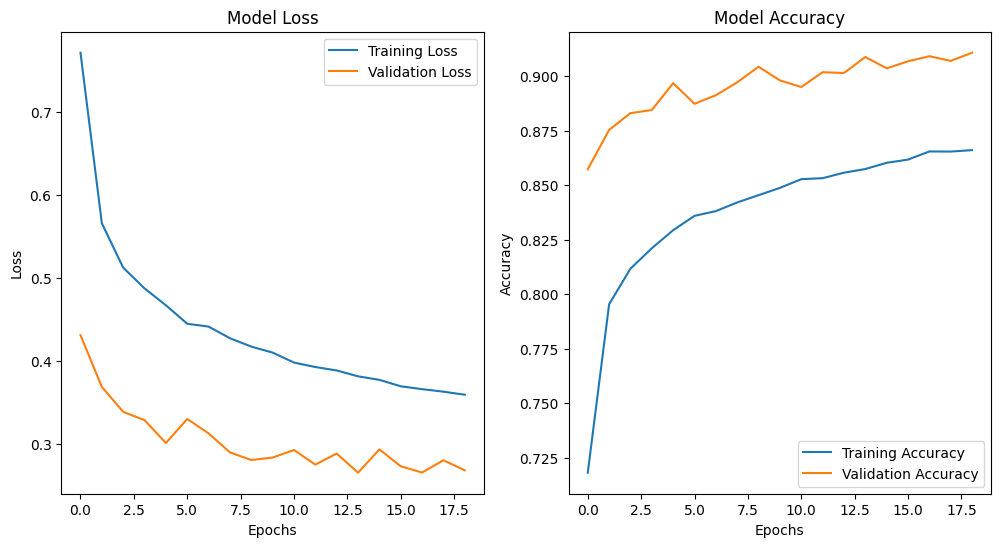

In [20]:
# Learning Curve for the best model
# Plot the Learning Curve
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label  = 'Training Loss')
plt.plot(best_history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

IMPORTANT NOTE:

I couldn't run the best model with early stopping using GPU (like I did with random search), and this could have resolved a little bit the issue of training metrics being worse than validation. I finished free usage and couldn't wait because the deadline was close.

Notes:

Validation Accuracy using the best model with early stopping (even the one after random search) is around 91%. However training accuracy is still lower, around 87%. The best model from random search had a more complex model, which tried to learn more the data, overcome underfitting and get a better accuracy/ lower error.
These results are close to the previous ones.

## 4. Model Evaluation on testing set

Evaluate your best model on the testing set and show that you can achieve an accuracy and F1-measure over 90%

In [22]:
# Model Evaluation on the Testing Set
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9058 - loss: 0.2595
Test Accuracy:  0.9087173938751221


In [24]:
# F1 Score
from sklearn.metrics import f1_score
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)

y_true = np.argmax(Y_test, axis = 1)

f1 = f1_score(y_true, y_pred, average = 'weighted')
print("F1 Score: ", f1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
F1 Score:  0.9077723841328859


IMPORTANT NOTE
Please note that I couldn't run best model with early stopping with GPU, which resulted in it having less accuracy than when it was done with random search.
However, I was able to achieve an accuracy and f1 over 90%

Print the Confusion matrix and show the F1-measur for each class. Explain your results

In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[678   0   0   0   0   1   0  21   0   0]
 [  0 354  20   0   1   0  11   0  33   1]
 [  0  24 645   0   7   0   6   0   3  14]
 [  0   1   3 550   0   0   3   1   2   0]
 [  0   1  15   0 682   0   0   0   1   1]
 [ 12   0   0   2   0 668   0  17   1   0]
 [  0  33  15   2   0   0 152   0  26  52]
 [ 29   0   0   0   0   6   0 665   0   0]
 [  0  51   8   2   0   0  28   0 399   1]
 [  0   2  16   5   1   0  27   0   5 294]]


The confusion matrix shows us that the model performed well as most classes were correctly predicted. However, regarding misclassification, we can observe some patterns.

For example, most misclassified ankle boots (class 0) were predicted as sneakers (class 7). Since both of them are types of shoes, it is expected that their pattern are close to each other. Same for Top and Shirt.

In [31]:
# Classification Report to see F1 and other metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names = encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

  Ankle boot       0.94      0.97      0.96       700
        Coat       0.76      0.84      0.80       420
       Dress       0.89      0.92      0.91       699
     Handbag       0.98      0.98      0.98       560
       Pants       0.99      0.97      0.98       700
      Sandal       0.99      0.95      0.97       700
       Shirt       0.67      0.54      0.60       280
     Sneaker       0.94      0.95      0.95       700
     Sweater       0.85      0.82      0.83       489
         Top       0.81      0.84      0.82       350

    accuracy                           0.91      5598
   macro avg       0.88      0.88      0.88      5598
weighted avg       0.91      0.91      0.91      5598



We can see that underrepresented classes have bad F1 scores (such as shirt, coat or top). This is mainly due because of their misrepresentation. The other classes have high f1 score.

Shirts have the lowest F1 score (0.6)because of the poor recall suggesting it is misclassified into other categories (mainly top and coat because of them belonging to the same category of clothes).

Other categories that have high F1 scores (96%) such as ankle boots show that the model learned the pattern correctly, mainly due to their high representation.

This suggests that generated data didn't let the model to learn more complex patterns.